<a href="https://colab.research.google.com/github/vNexif/Captcha_AI/blob/main/Captcha_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!python captcha_generation.py

Generating image 0 of 100000
Generating image 10000 of 100000
Generating image 20000 of 100000
Generating image 30000 of 100000
Generating image 40000 of 100000
Generating image 50000 of 100000
Generating image 60000 of 100000
Generating image 70000 of 100000
Generating image 80000 of 100000
Generating image 90000 of 100000
Generating image 0 of 10000


In [40]:
#Import fastai libraries
import models
import json

from config import CAP_LEN, TRAIN_DIR, TEST_DIR, EPOCHS, LOG_INTERVAL, SEED, LR, BATCH_SIZE, CHARACTERS, RESULT_FILE_NAME, NO_TRAIN_CAP, NO_TEST_CAP, DES_PATH, OUT_FILENAME
from utils import train, test, get_target_from_indices, get_preds_from_output, get_transformation
from os.path import join

from fastai.vision import *
from fastai.callback import *
from fastai import *

from pathlib import Path

import os
import pandas as pd
from captcha.image import ImageCaptcha
from shutil import copyfile


from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms




In [4]:
# Get all the inputs and targets from image files and save it to labels

def process_filename(filename):
    text = filename.split('_')[0]
    return list(map(lambda x: f'{x[1]}{x[0]}', enumerate(text)))

path = Path('captcha_img')
rows = []
for filename in os.listdir(path/'train'):
    if not filename.endswith('png'):
        continue
    rows.append((os.path.join('train', filename), process_filename(filename), False))

for filename in os.listdir(path/'valid'):
    if not filename.endswith('png'):
        continue
    rows.append((os.path.join('valid', filename), process_filename(filename), True))
    
df = pd.DataFrame(rows, columns=['name', 'label', 'is_valid'])

df.head()

,name,label,is_valid
0,train/38H4_0.png,"[30, 81, H2, 43]",False
1,train/GRHH_0.png,"[G0, R1, H2, H3]",False
2,train/M3U1_0.png,"[M0, 31, U2, 13]",False
3,train/RS5E_0.png,"[R0, S1, 52, E3]",False
4,train/YUY5_0.png,"[Y0, U1, Y2, 53]",False


In [5]:
# Create a databunch object for the fastai learner
path = Path('captcha_img')
il = ImageList.from_df(df, path).split_from_df().label_from_df()
data = il.databunch()

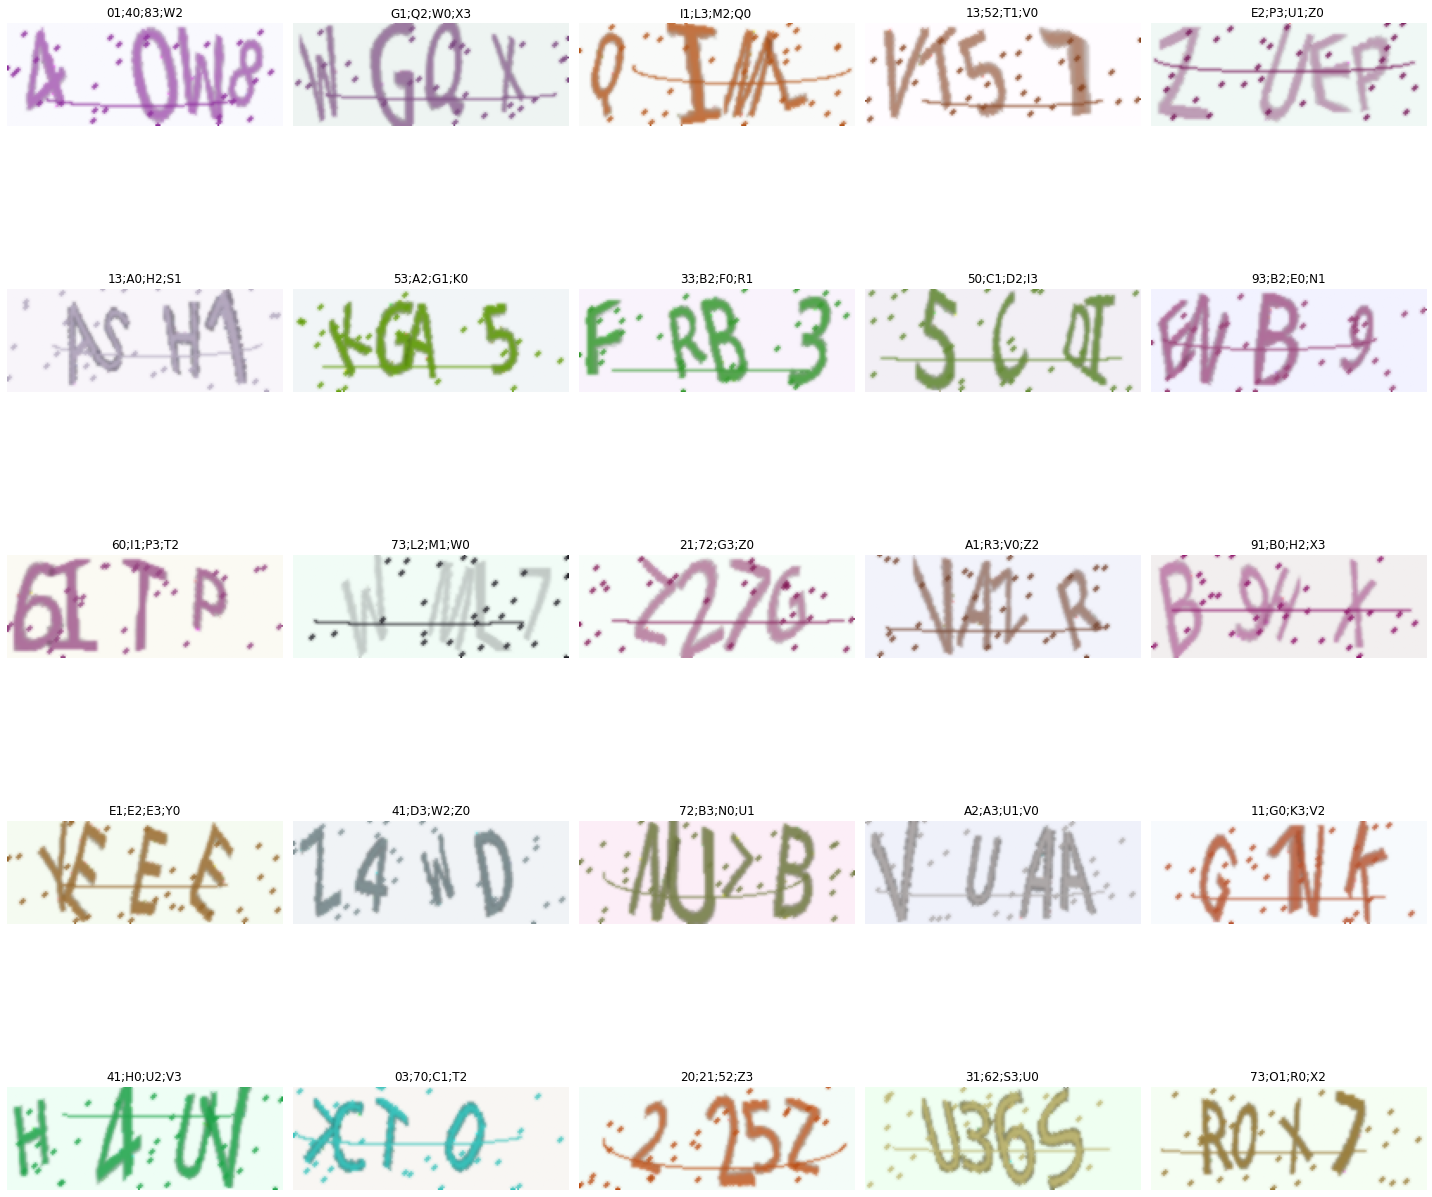

In [6]:
data.show_batch()

In [7]:
def captcha_accuracy(y_pred, y_true, get_mean=True):
    sorted_pred, _ = y_pred.sort(1)
    y_pred = y_pred >= sorted_pred[:, -4].float().view((-1, 1))
    y_true = y_true.byte()
    
    result = (((y_pred == y_true) & (y_true == 1)).float().sum(1) / 4.)
    if get_mean == True:
        result = result.mean()
    return result


In [8]:
learn = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,captcha_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


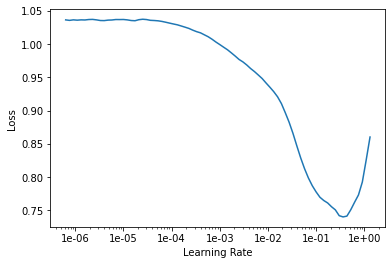

In [9]:
learn.lr_find()
learn.recorder.plot(skip_end=5)

In [11]:
learn.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

epoch,train_loss,valid_loss,captcha_accuracy,time
0,0.011840,0.012185,0.946400,04:03
1,0.003573,0.002976,0.971175,04:02


In [12]:
learn.save('res-default')

In [13]:
def get_preds_with_top_loss_idx(learn):
    y_pred, y_true, losses = learn.get_preds(with_loss=True)
    acc = captcha_accuracy(y_pred, y_true, get_mean=False)
    sorted_pred, _ = y_pred.sort(1)
    losses = losses.view((-1, 144)).mean(1)    
    top_loss_idx = losses.argsort(descending=True)
    
    y_pred = y_pred >= sorted_pred[:, -4].float().view((-1, 1))
    return y_pred, y_true, losses, top_loss_idx, acc

def show_top_losses(learn, row=3):
    y_pred, y_true, losses, top_loss_idx, acc = get_preds_with_top_loss_idx(learn)
    axs = subplots(row, row, figsize=(20, 10), title='index / pred / true / loss / accuracy').reshape(-1)
    y_recon = data.valid_ds.y.reconstruct
    for idx, ax in zip(top_loss_idx[:row*row], axs):
        title = f"{idx} / {y_recon(y_pred[idx])} / {y_recon(y_true[idx])} / {losses[idx]:0.3f} / {acc[idx]:0.2f}"
        ax = show_image(data.valid_ds[idx][0], ax=ax)
        ax.set_title(title)

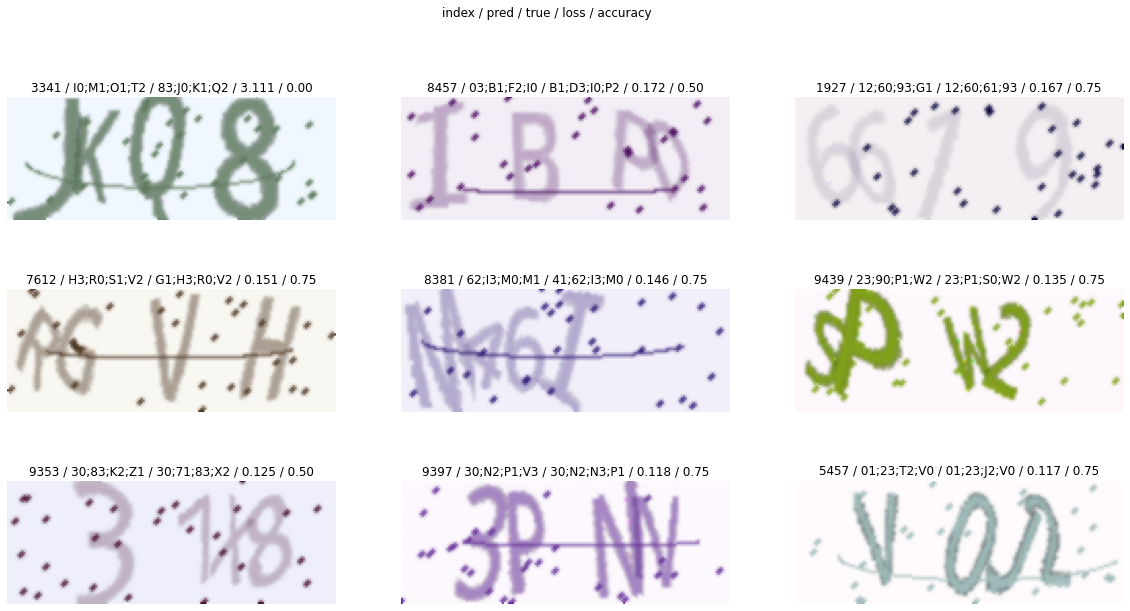

In [14]:
show_top_losses(learn)

In [15]:
learn2 = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False, wd=0.05, ps=0.2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
learn2.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

epoch,train_loss,valid_loss,captcha_accuracy,time
0,0.016126,0.028716,0.874800,04:03
1,0.003229,0.002845,0.969800,04:02


In [17]:
learn2.save('res-0.05-0.2')

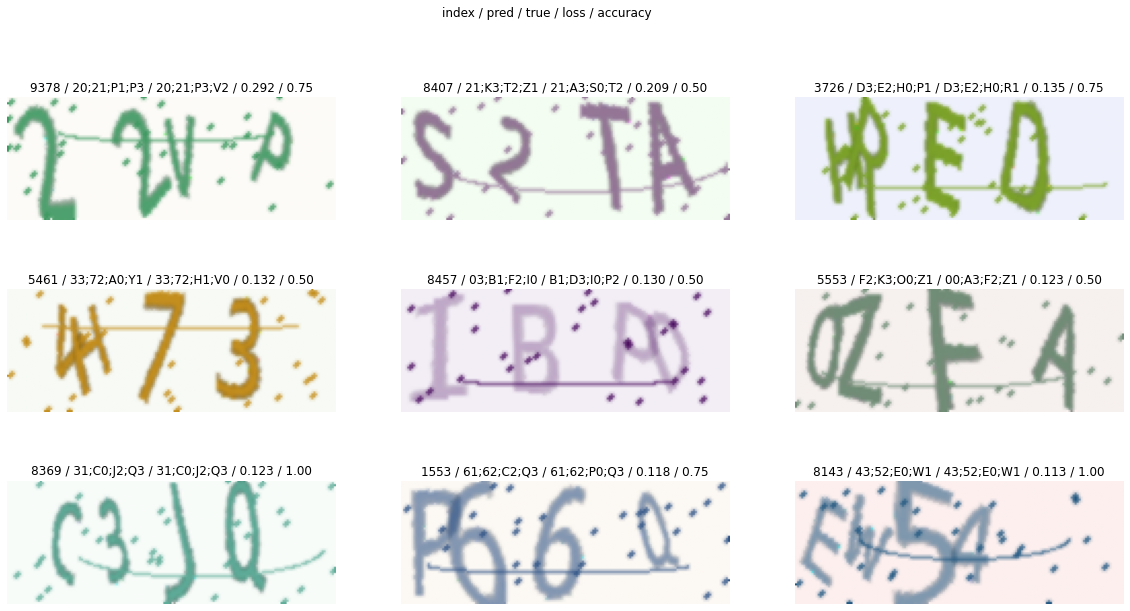

In [18]:
show_top_losses(learn2)

In [19]:
learn3 = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False, wd=0.02, ps=0.2)
learn3.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,captcha_accuracy,time
0,0.013279,0.015379,0.924325,04:03
1,0.002626,0.002550,0.982625,04:03


In [20]:
learn3.save('res-0.02-0.2')

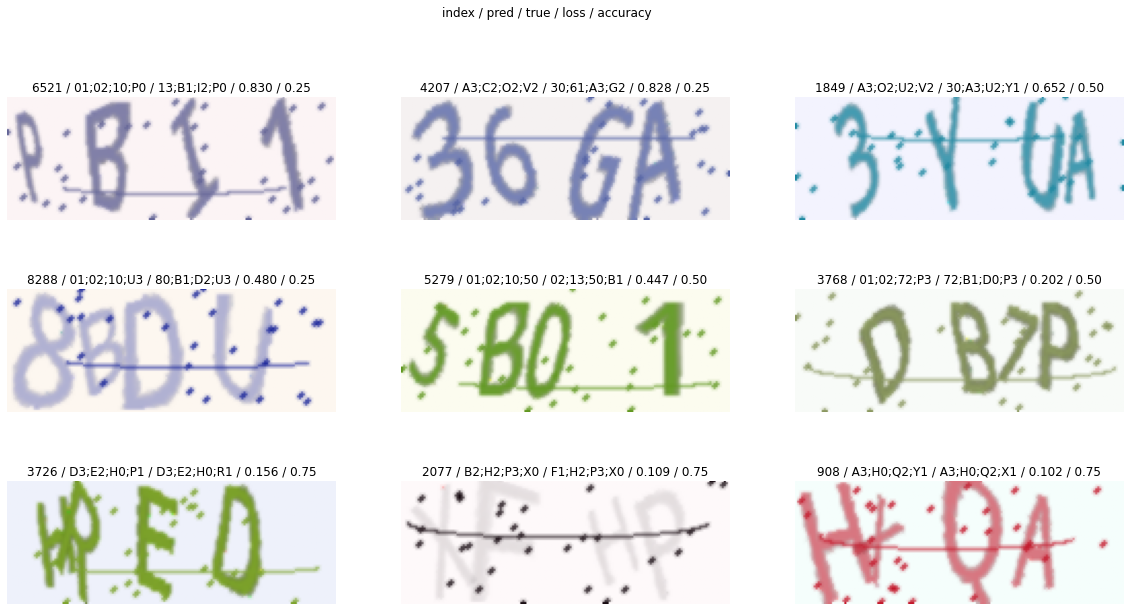

In [21]:
show_top_losses(learn3)

In [22]:
learn4 = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False, wd=0.01, ps=0.2)
learn4.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,captcha_accuracy,time
0,0.016643,0.030625,0.875500,04:03
1,0.003270,0.003126,0.976975,04:02


In [23]:
learn4.save('res-0.01-0.2')

In [24]:
learn5 = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False, wd=0.01, ps=0.1)
learn5.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

epoch,train_loss,valid_loss,captcha_accuracy,time
0,0.013299,0.084499,0.920075,04:03
1,0.002600,0.006118,0.982800,04:03


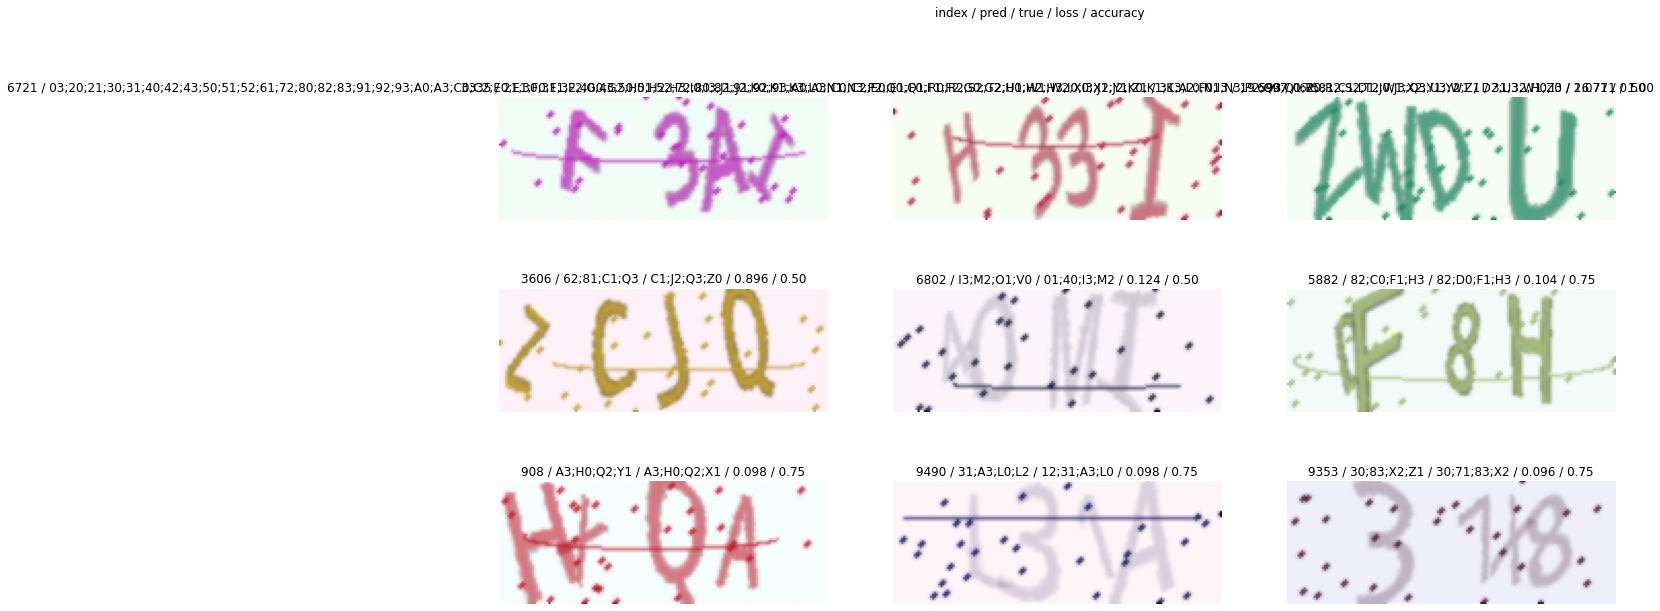

In [25]:
show_top_losses(learn5)

In [26]:
learn5.save('res-0.01-0.1')

In [27]:
learn2.lr_find()

epoch,train_loss,valid_loss,captcha_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


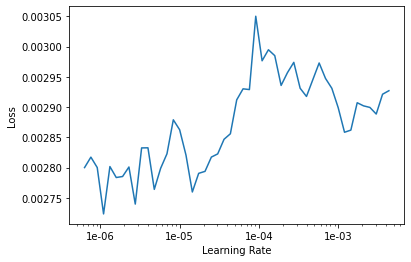

In [28]:
learn2.recorder.plot(skip_end=10)

In [29]:
learn2.fit_one_cycle(1, max_lr=slice(1e-6,5e-5))

epoch,train_loss,valid_loss,captcha_accuracy,time
0,0.002906,0.003872,0.971025,04:22


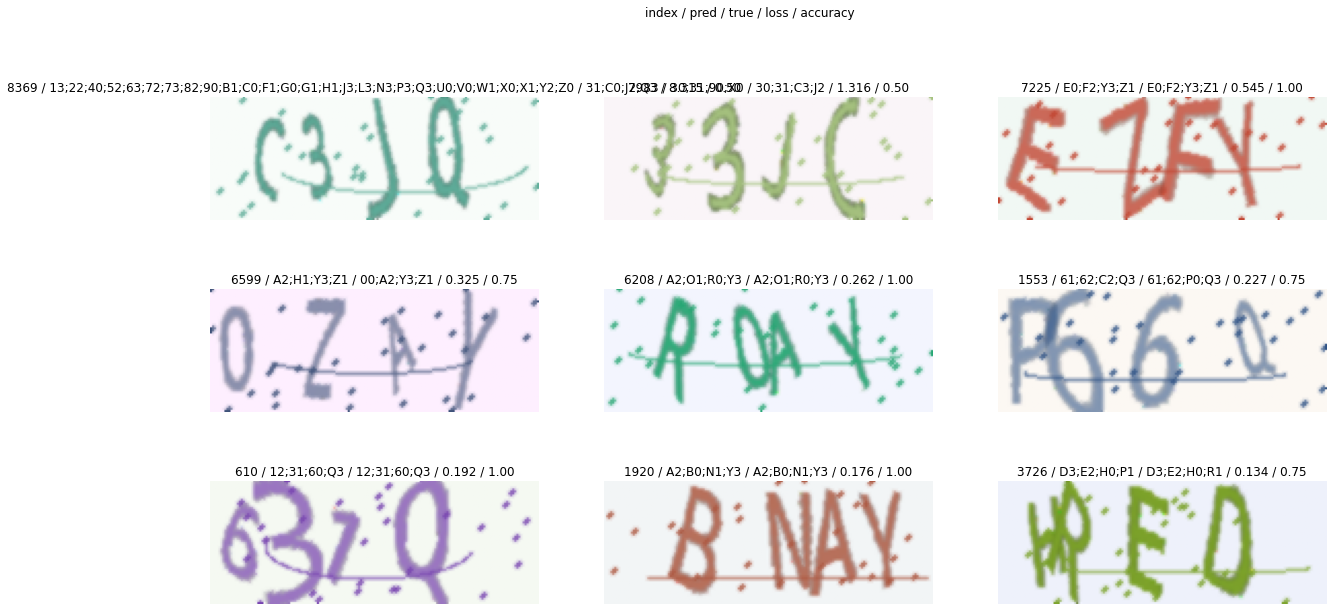

In [30]:
show_top_losses(learn2)

In [31]:
learn2.save('res-0.05-0.2-stage2')

In [32]:
learn2 = learn2.load('res-0.05-0.2-stage2')

In [43]:
def hooked_backward(learn, xb, layer_idx):
    m = learn.model.eval()
    with hook_output(m[0][layer_idx]) as hook_a:
            preds = m(xb)
    return hook_a,hook_g


def show_heatmap(hm, x_im, item_idx, layer_idx, ax):
    x_im.show(ax, title=f'layer {layer_idx}, item {item_idx}')
    ax.imshow(hm, alpha=0.6, extent=(0,160, 60,0),
              interpolation='bilinear', cmap='magma');

def visualize_layer_of_item(learn, item_idxes, layer_idxes, row=2):
    data = learn.data
    axes = subplots(row, row, figsize=(20, 10)).reshape(-1)
    for item_idx, layer_idx, ax in zip(item_idxes, layer_idxes, axes):
        x,y = data.valid_ds[item_idx]
        xb, _ = data.one_item(x)

        hook_a,hook_g = hooked_backward(learn, xb.cuda(), layer_idx)
        acts  = hook_a.stored[0].cpu()
        avg_acts = acts.mean(0)

        show_heatmap(avg_acts, x, item_idx, layer_idx, ax)

AttributeError: ignored

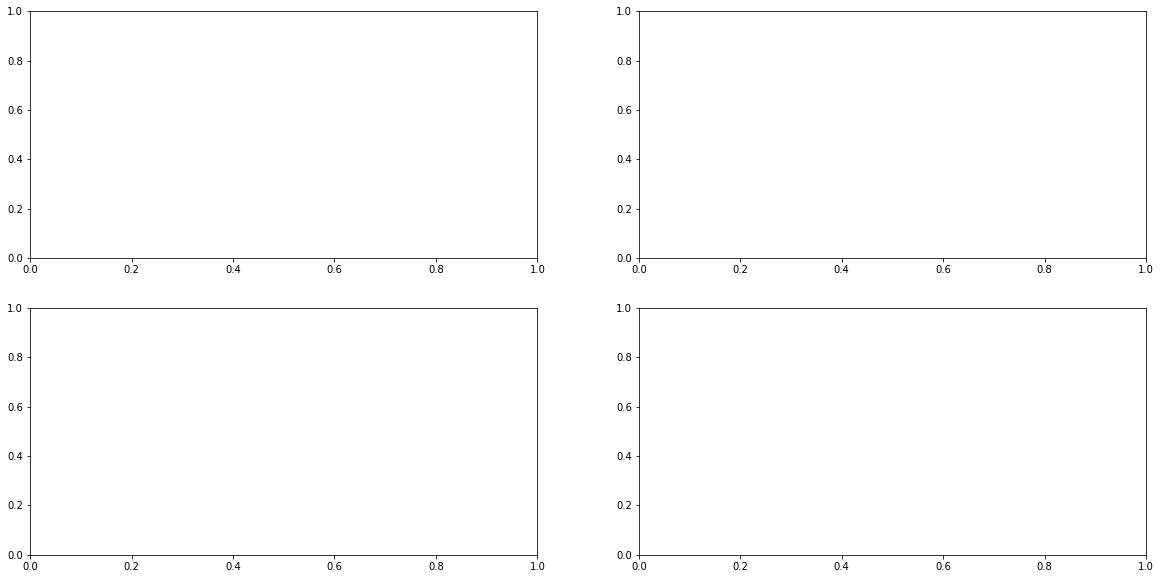

In [44]:
visualize_layer_of_item(learn2, [9000, 9001, 9000, 9000], [5, 5, 6, 7])